In [9]:
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import random
import cv2
from PIL import Image
pd.set_option('display.max_columns', None)
import albumentations
from albumentations.pytorch.transforms import ToTensorV2
import torch
import torchvision
import timm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
RANDOM_SEED = 15

## 1. Description
###  Objective
The primary goal of this project is to develop a deep learning model that can predict the "Pawpularity" score of pet images. Pawpularity is a metric used by PetFinder.my to gauge the appeal of a pet's photo to online browsers, which can influence the pet's chances of adoption.

In [2]:
# Load the metadata
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

# Print dataset sizes
print(f"Training set size: {len(train)}")
print(f"Test set size: {len(test)}")


# Print data types and non-null counts
print("\nDataset Info:")
train.info()

Training set size: 9912
Test set size: 8

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9912 entries, 0 to 9911
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             9912 non-null   object
 1   Subject Focus  9912 non-null   int64 
 2   Eyes           9912 non-null   int64 
 3   Face           9912 non-null   int64 
 4   Near           9912 non-null   int64 
 5   Action         9912 non-null   int64 
 6   Accessory      9912 non-null   int64 
 7   Group          9912 non-null   int64 
 8   Collage        9912 non-null   int64 
 9   Human          9912 non-null   int64 
 10  Occlusion      9912 non-null   int64 
 11  Info           9912 non-null   int64 
 12  Blur           9912 non-null   int64 
 13  Pawpularity    9912 non-null   int64 
dtypes: int64(13), object(1)
memory usage: 1.1+ MB


In [3]:
# Load and print dimensions of a few images
print("\nImage Dimensions:")
image_dir = './data/train'  # Update this to your image directory path
for i in range(5):  # Check first 5 images
    img_path = os.path.join(image_dir, train.loc[i, 'Id'] + '.jpg')
    with Image.open(img_path) as img:
        print(f"Image {i+1}: {img.size}")

# Print unique values in categorical columns
categorical_col = train.columns.tolist()[1:-1]
print("\nUnique values in categorical columns:")
for col in categorical_col:
    print(f"{col}: {train[col].unique()}")


Image Dimensions:
Image 1: (405, 720)
Image 2: (1032, 774)
Image 3: (720, 960)
Image 4: (405, 720)
Image 5: (540, 960)

Unique values in categorical columns:
Subject Focus: [0 1]
Eyes: [1 0]
Face: [1 0]
Near: [1 0]
Action: [0 1]
Accessory: [0 1]
Group: [1 0]
Collage: [0 1]
Human: [0 1]
Occlusion: [0 1]
Info: [0 1]
Blur: [0 1]


## 2. EDA

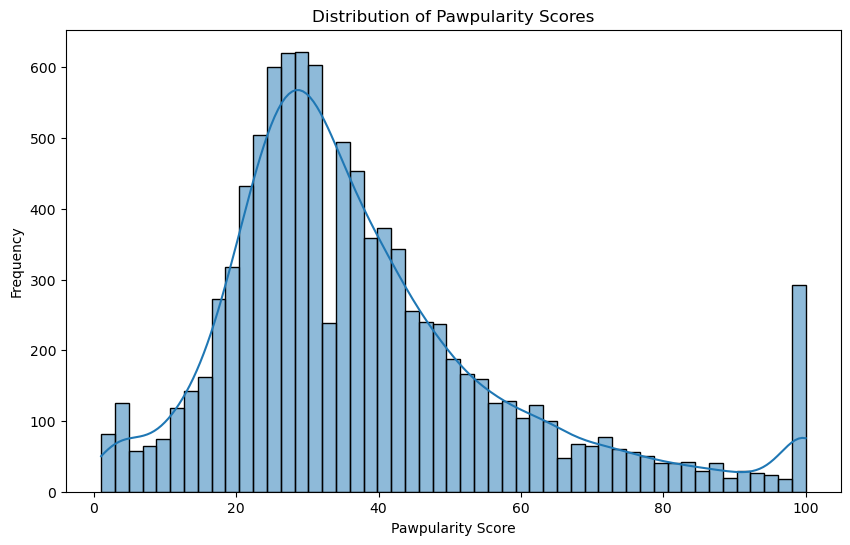

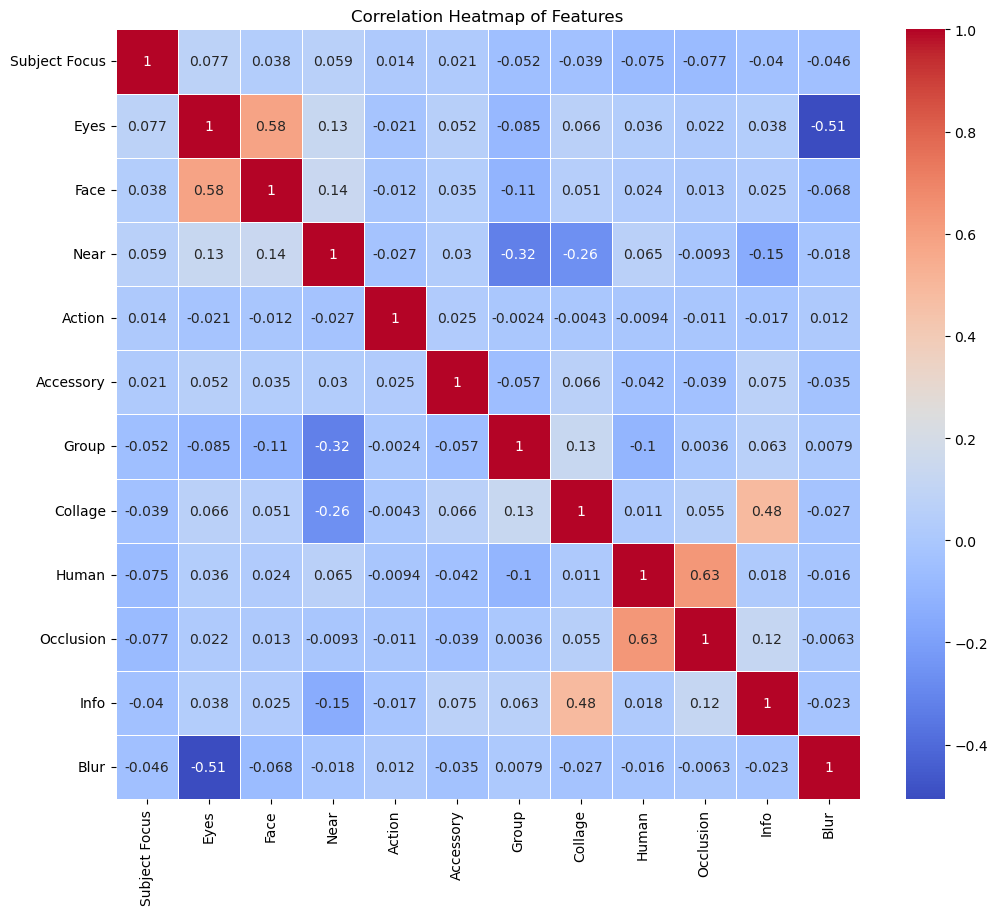

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

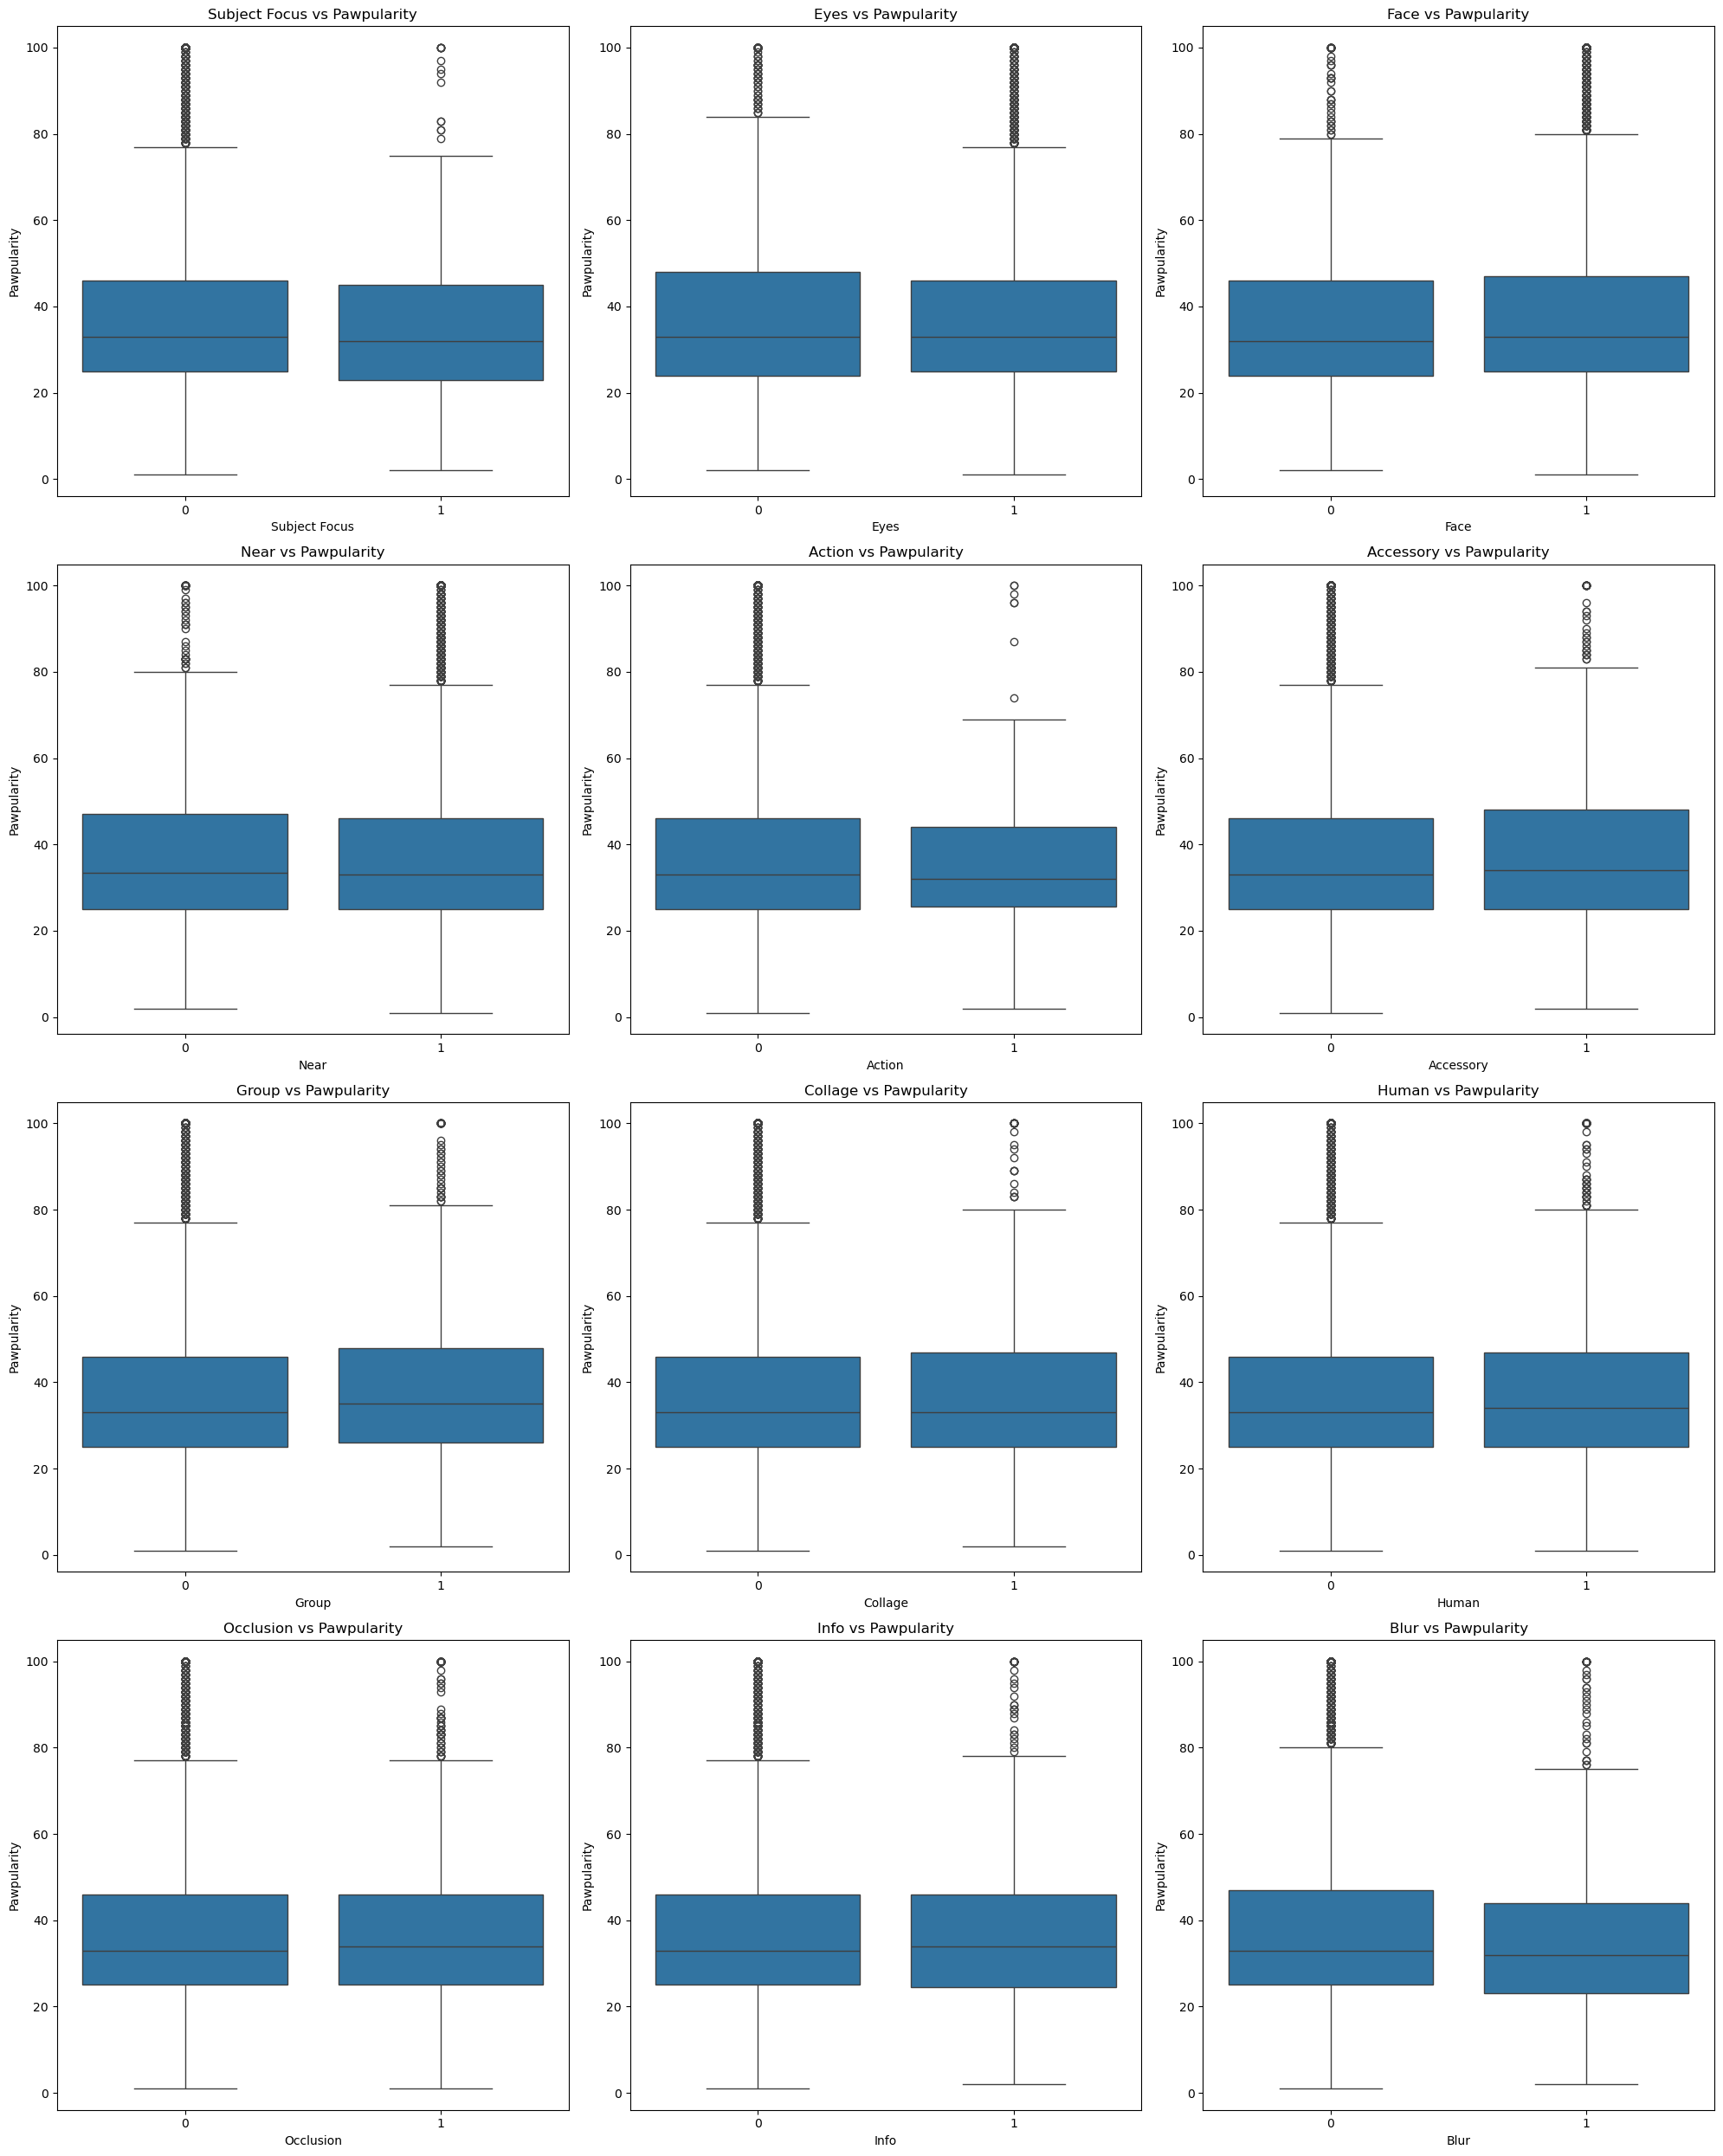

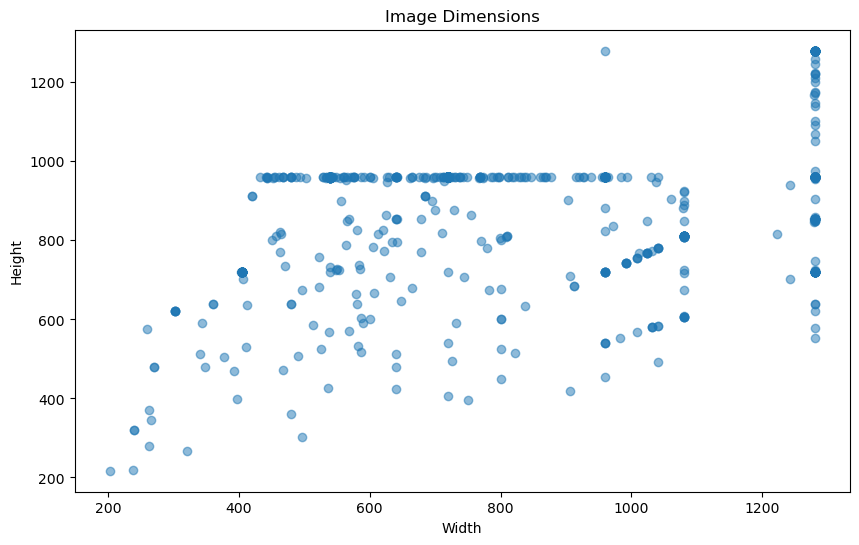

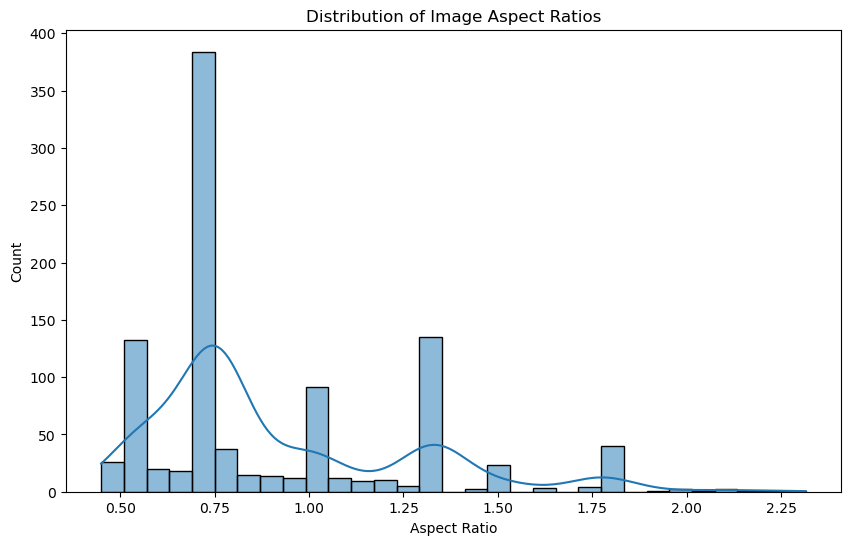

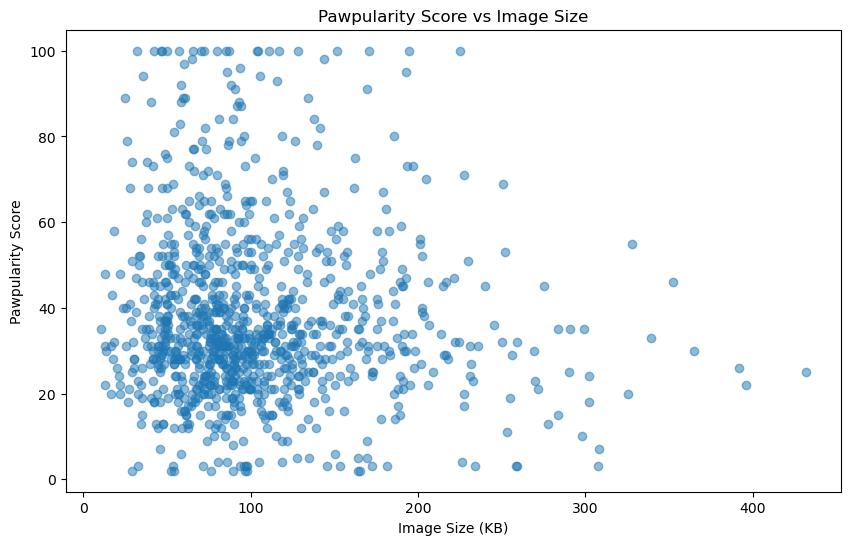

In [4]:
# 1. Distribution of Pawpularity Scores
plt.figure(figsize=(10, 6))
sns.histplot(train['Pawpularity'], kde=True)
plt.title('Distribution of Pawpularity Scores')
plt.xlabel('Pawpularity Score')
plt.ylabel('Frequency')
plt.show()

# 2. Correlation between features
correlation_matrix = train[categorical_col].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Features')
plt.show()

# 3. Relationship between individual features and Pawpularity
feature_cols = ['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 
                'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur']

fig, axes = plt.subplots(4, 3, figsize=(20, 25))
axes = axes.flatten()

for i, col in enumerate(feature_cols):
    sns.boxplot(x=col, y='Pawpularity', data=train, ax=axes[i])
    axes[i].set_title(f'{col} vs Pawpularity')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Pawpularity')

plt.tight_layout()
plt.show()

# 4. Image analysis
def analyze_image(image_path):
    img = Image.open(image_path)
    return {
        'width': img.size[0],
        'height': img.size[1],
        'aspect_ratio': img.size[0] / img.size[1],
        'size': os.path.getsize(image_path) / 1024  # size in KB
    }

image_dir = './data/train'  # Update this to your image directory path
image_data = []

for i, row in train.iterrows():
    if i > 1000:  # Limit to first 1000 images for speed
        break
    img_path = os.path.join(image_dir, row['Id'] + '.jpg')
    image_data.append(analyze_image(img_path))

image_df = pd.DataFrame(image_data)

# Plot image dimensions
plt.figure(figsize=(10, 6))
plt.scatter(image_df['width'], image_df['height'], alpha=0.5)
plt.title('Image Dimensions')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()

# Plot aspect ratio distribution
plt.figure(figsize=(10, 6))
sns.histplot(image_df['aspect_ratio'], kde=True)
plt.title('Distribution of Image Aspect Ratios')
plt.xlabel('Aspect Ratio')
plt.show()

# 5. Pawpularity score vs image features
plt.figure(figsize=(10, 6))
plt.scatter(image_df['size'], train['Pawpularity'].iloc[:1001], alpha=0.5)
plt.title('Pawpularity Score vs Image Size')
plt.xlabel('Image Size (KB)')
plt.ylabel('Pawpularity Score')
plt.show()

## 3. Architecture

- Convolutional Neural Network (CNN) from scratch
- Transfer Learning model using a pre-trained network (e.g., ResNet50)
- A traditional machine learning model (e.g., Random Forest) as a baseline

In [5]:
device = torch.device("mps" if torch.backends.mps.is_built() else "cpu")

# Custom Dataset
class PetFinderDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.dataframe.iloc[idx, 0] + '.jpg')
        image = Image.open(img_name).convert('RGB')
        pawpularity = self.dataframe.iloc[idx, -1]
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(pawpularity, dtype=torch.float32).view(1)

# Data Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets and dataloaders
train_df, val_df = train_test_split(train, test_size=0.2, random_state=42)


train_dataset = PetFinderDataset(train_df, './data/train', transform=transform)
val_dataset = PetFinderDataset(val_df, './data/train', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=0)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")


Number of training samples: 7929
Number of validation samples: 1983


In [6]:
class SimpleCNN(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Calculate the size of the flattened feature map
        self.feature_size = self._get_conv_output((3, 224, 224))
        
        self.fc1 = nn.Linear(self.feature_size, 64)
        self.fc2 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(dropout_rate)

    def _get_conv_output(self, shape):
        input = torch.rand(1, *shape)
        output = self._forward_conv(input)
        return int(torch.prod(torch.tensor(output.size())))

    def _forward_conv(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = torch.relu(self.conv3(x))
        return x

    def forward(self, x):
        x = self._forward_conv(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class TransferLearningModel(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(TransferLearningModel, self).__init__()
        self.resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        for param in self.resnet.parameters():
            param.requires_grad = False
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_ftrs, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.resnet(x)

## 4. Results and Analysis
### 1. Hyperparameter Tuning

In [7]:
import optuna

class PyTorchModel:
    def __init__(self, model_class, **kwargs):
        self.model = model_class(**kwargs)
        self.model.to(device)

    def fit(self, train_loader, val_loader, num_epochs, learning_rate, trial=None):
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)

        patience = 3
        best_val_loss = float('inf')
        best_rmse = float('inf')

        for epoch in range(num_epochs):
            self.model.train()
            train_loss = 0.0
            for inputs, targets in train_loader:
                inputs, targets = inputs.to(device), targets.to(device).view(-1, 1)
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
            
                train_loss += loss.item()
            
            # Validation
            val_loss, rmse = self.evaluate_model(val_loader, criterion)

            print(f'Epoch {epoch+1}/{num_epochs}')
            print(f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val RMSE: {rmse:.4f}')
        
            # Early stopping check
            if rmse < best_rmse:
                best_rmse = rmse
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    break
            
            if trial:
                # Report intermediate value
                trial.report(rmse, epoch)

                # Handle pruning based on the intermediate value
                if trial.should_prune():
                    raise optuna.TrialPruned()
        
        return val_loss, best_rmse
    
    def evaluate_model(self, dataloader, criterion):
        self.model.eval()
        val_loss = 0.0
        all_preds = []
        all_targets = []
        
        with torch.no_grad():
            for inputs, targets in dataloader:
                inputs, targets = inputs.to(device), targets.to(device).view(-1, 1)
                
                outputs = self.model(inputs)
                loss = criterion(outputs, targets)
                
                val_loss += loss.item() * inputs.size(0)
                
                all_preds.extend(outputs.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())
        
        val_loss = val_loss / len(dataloader.dataset)
        rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
        
        return val_loss, rmse

def objective(trial, model_class, train_loader, val_loader):
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True) 
    batch_size = trial.suggest_categorical('batch_size', [32, 64])
    num_epochs = trial.suggest_int('num_epochs', 6, 20)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.6)

    model = PyTorchModel(model_class, dropout_rate=dropout_rate)
    val_loss, rmse = model.fit(train_loader, val_loader, num_epochs, learning_rate, trial)

    return rmse

In [10]:
# Optuna study setup with pruning
sampler = optuna.samplers.TPESampler()
pruner = optuna.pruners.MedianPruner()

# Create separate studies for CNN and ResNet
cnn_study = optuna.create_study(direction='minimize', sampler=sampler, pruner=pruner)
resnet_study = optuna.create_study(direction='minimize', sampler=sampler, pruner=pruner)

n_trials = 5
try:
    cnn_study.optimize(lambda trial: objective(trial, SimpleCNN, train_loader, val_loader), n_trials=n_trials)
except KeyboardInterrupt:
    print("CNN optimization was interrupted.")

try:
    resnet_study.optimize(lambda trial: objective(trial, TransferLearningModel, train_loader, val_loader), n_trials=n_trials)
except KeyboardInterrupt:
    print("ResNet optimization was interrupted.")

# Print results for CNN
print('Best CNN trial:')
cnn_trial = cnn_study.best_trial
print('  RMSE: ', cnn_trial.value)
print('  Params: ')
for key, value in cnn_trial.params.items():
    print('    {}: {}'.format(key, value))

# Print results for ResNet
print('\nBest ResNet trial:')
resnet_trial = resnet_study.best_trial
print('  RMSE: ', resnet_trial.value)
print('  Params: ')
for key, value in resnet_trial.params.items():
    print('    {}: {}'.format(key, value))

# Compare the best models
print("\nModel Comparison:")
print(f"CNN Best RMSE: {cnn_trial.value:.4f}")
print(f"ResNet Best RMSE: {resnet_trial.value:.4f}")

if cnn_trial.value > resnet_trial.value:
    print("CNN outperformed ResNet")
else:
    print("ResNet outperformed CNN")

[I 2024-08-17 01:26:32,781] A new study created in memory with name: no-name-743a9876-d7a3-4f73-87ec-4f127e0fb8a7
[I 2024-08-17 01:26:32,782] A new study created in memory with name: no-name-896a8008-109b-49a4-9ed7-ba83fc2aa5f4


Epoch 1/12
Train Loss: 115215.4854, Val Loss: 565.3566, Val RMSE: 23.7772
Epoch 2/12
Train Loss: 106128.5871, Val Loss: 729.2837, Val RMSE: 27.0053
Epoch 3/12
Train Loss: 103149.8557, Val Loss: 591.3337, Val RMSE: 24.3174
Epoch 4/12
Train Loss: 100878.1344, Val Loss: 514.4488, Val RMSE: 22.6815
Epoch 5/12
Train Loss: 95611.7845, Val Loss: 610.5494, Val RMSE: 24.7093
Epoch 6/12
Train Loss: 84055.8545, Val Loss: 516.8265, Val RMSE: 22.7338


[I 2024-08-17 01:35:34,255] Trial 0 finished with value: 22.68146324157715 and parameters: {'learning_rate': 0.0004148802156175438, 'batch_size': 32, 'num_epochs': 12, 'dropout_rate': 0.30321229514512515}. Best is trial 0 with value: 22.68146324157715.


Epoch 7/12
Train Loss: 64038.6050, Val Loss: 620.0131, Val RMSE: 24.9001
Epoch 1/19
Train Loss: 45989324463.5998, Val Loss: 1909.0031, Val RMSE: 43.6921
Epoch 2/19
Train Loss: 467075.6540, Val Loss: 1906.0965, Val RMSE: 43.6589
Epoch 3/19
Train Loss: 466451.3053, Val Loss: 1902.8376, Val RMSE: 43.6215
Epoch 4/19
Train Loss: 465522.9131, Val Loss: 1898.7101, Val RMSE: 43.5742
Epoch 5/19
Train Loss: 464387.3094, Val Loss: 1893.6942, Val RMSE: 43.5166
Epoch 6/19
Train Loss: 462956.3033, Val Loss: 1887.7467, Val RMSE: 43.4482
Epoch 7/19
Train Loss: 461594.5637, Val Loss: 1880.8024, Val RMSE: 43.3682
Epoch 8/19
Train Loss: 459549.6136, Val Loss: 1872.7577, Val RMSE: 43.2754
Epoch 9/19
Train Loss: 457424.9168, Val Loss: 1863.5360, Val RMSE: 43.1687
Epoch 10/19
Train Loss: 455237.4625, Val Loss: 1852.9888, Val RMSE: 43.0464
Epoch 11/19
Train Loss: 452548.1456, Val Loss: 1841.0446, Val RMSE: 42.9074
Epoch 12/19
Train Loss: 449020.6362, Val Loss: 1827.4749, Val RMSE: 42.7490
Epoch 13/19
Train L

[I 2024-08-17 02:00:35,368] Trial 1 finished with value: 40.91371154785156 and parameters: {'learning_rate': 0.0323749198278786, 'batch_size': 32, 'num_epochs': 19, 'dropout_rate': 0.28950646853030015}. Best is trial 0 with value: 22.68146324157715.


Epoch 19/19
Train Loss: 413007.9147, Val Loss: 1673.9318, Val RMSE: 40.9137
Epoch 1/10
Train Loss: 114603.9950, Val Loss: 574.5831, Val RMSE: 23.9705
Epoch 2/10
Train Loss: 107023.0174, Val Loss: 598.8291, Val RMSE: 24.4710
Epoch 3/10
Train Loss: 103349.7312, Val Loss: 621.2069, Val RMSE: 24.9240
Epoch 4/10
Train Loss: 101987.3266, Val Loss: 568.4429, Val RMSE: 23.8420
Epoch 5/10
Train Loss: 99100.8830, Val Loss: 688.3578, Val RMSE: 26.2366
Epoch 6/10
Train Loss: 93668.1591, Val Loss: 543.7025, Val RMSE: 23.3174
Epoch 7/10
Train Loss: 86103.2220, Val Loss: 661.6102, Val RMSE: 25.7218
Epoch 8/10
Train Loss: 77309.2704, Val Loss: 489.1244, Val RMSE: 22.1162
Epoch 9/10
Train Loss: 69137.5493, Val Loss: 527.7839, Val RMSE: 22.9735


[I 2024-08-17 02:14:32,593] Trial 2 finished with value: 22.11615753173828 and parameters: {'learning_rate': 0.00012733874379723407, 'batch_size': 64, 'num_epochs': 10, 'dropout_rate': 0.3061675914562304}. Best is trial 2 with value: 22.11615753173828.


Epoch 10/10
Train Loss: 59364.8023, Val Loss: 584.1656, Val RMSE: 24.1695
Epoch 1/8
Train Loss: 133490.2264, Val Loss: 508.2261, Val RMSE: 22.5439
Epoch 2/8
Train Loss: 110788.8038, Val Loss: 482.1223, Val RMSE: 21.9573
Epoch 3/8
Train Loss: 107272.1113, Val Loss: 481.5972, Val RMSE: 21.9453
Epoch 4/8
Train Loss: 105214.7384, Val Loss: 469.5688, Val RMSE: 21.6695
Epoch 5/8
Train Loss: 103960.0945, Val Loss: 486.1253, Val RMSE: 22.0483
Epoch 6/8
Train Loss: 103380.6144, Val Loss: 512.1487, Val RMSE: 22.6307


[I 2024-08-17 02:24:17,601] Trial 3 finished with value: 21.669536590576172 and parameters: {'learning_rate': 2.5177669031357237e-05, 'batch_size': 32, 'num_epochs': 8, 'dropout_rate': 0.17956545378570424}. Best is trial 3 with value: 21.669536590576172.


Epoch 7/8
Train Loss: 102634.1736, Val Loss: 534.0084, Val RMSE: 23.1086
Epoch 1/16
Train Loss: 119106.2252, Val Loss: 911.8624, Val RMSE: 30.1971
Epoch 2/16
Train Loss: 106831.6193, Val Loss: 905.0298, Val RMSE: 30.0837
Epoch 3/16
Train Loss: 104897.8351, Val Loss: 867.8388, Val RMSE: 29.4591
Epoch 4/16
Train Loss: 103745.0936, Val Loss: 822.0266, Val RMSE: 28.6710
Epoch 5/16
Train Loss: 99124.4518, Val Loss: 810.0256, Val RMSE: 28.4609
Epoch 6/16
Train Loss: 87192.3577, Val Loss: 796.0008, Val RMSE: 28.2135
Epoch 7/16
Train Loss: 67365.0058, Val Loss: 793.0043, Val RMSE: 28.1603
Epoch 8/16
Train Loss: 40034.5493, Val Loss: 867.8760, Val RMSE: 29.4597
Epoch 9/16
Train Loss: 21219.1202, Val Loss: 844.8504, Val RMSE: 29.0663


[I 2024-08-17 02:37:35,243] Trial 4 finished with value: 28.16033172607422 and parameters: {'learning_rate': 0.0009932355357308996, 'batch_size': 32, 'num_epochs': 16, 'dropout_rate': 0.5182300462778057}. Best is trial 3 with value: 21.669536590576172.


Epoch 10/16
Train Loss: 13669.4032, Val Loss: 887.0194, Val RMSE: 29.7829
Epoch 1/6
Train Loss: 101587.7205, Val Loss: 594.4563, Val RMSE: 24.3815
Epoch 2/6
Train Loss: 92019.2351, Val Loss: 514.1875, Val RMSE: 22.6757
Epoch 3/6
Train Loss: 89030.6312, Val Loss: 556.7778, Val RMSE: 23.5961
Epoch 4/6
Train Loss: 87938.1149, Val Loss: 641.5886, Val RMSE: 25.3296


[I 2024-08-17 02:45:49,886] Trial 0 finished with value: 22.675701141357422 and parameters: {'learning_rate': 0.004269166633215917, 'batch_size': 64, 'num_epochs': 6, 'dropout_rate': 0.3809005759149967}. Best is trial 0 with value: 22.675701141357422.


Epoch 5/6
Train Loss: 87051.2610, Val Loss: 561.0535, Val RMSE: 23.6866
Epoch 1/9
Train Loss: 307337.4951, Val Loss: 949.1381, Val RMSE: 30.8081
Epoch 2/9
Train Loss: 132839.4496, Val Loss: 599.9112, Val RMSE: 24.4931
Epoch 3/9
Train Loss: 109516.7065, Val Loss: 548.4954, Val RMSE: 23.4200
Epoch 4/9
Train Loss: 108403.5072, Val Loss: 545.4636, Val RMSE: 23.3552
Epoch 5/9
Train Loss: 107481.6284, Val Loss: 542.4491, Val RMSE: 23.2905
Epoch 6/9
Train Loss: 105692.1158, Val Loss: 547.8550, Val RMSE: 23.4063
Epoch 7/9
Train Loss: 104738.6162, Val Loss: 534.4223, Val RMSE: 23.1176
Epoch 8/9
Train Loss: 103310.8868, Val Loss: 521.2600, Val RMSE: 22.8311


[I 2024-08-17 03:00:38,548] Trial 1 finished with value: 22.7550048828125 and parameters: {'learning_rate': 2.7615119962591712e-05, 'batch_size': 64, 'num_epochs': 9, 'dropout_rate': 0.22854458001670577}. Best is trial 0 with value: 22.675701141357422.


Epoch 9/9
Train Loss: 101559.4300, Val Loss: 517.7902, Val RMSE: 22.7550
Epoch 1/19
Train Loss: 140455.3966, Val Loss: 689.9599, Val RMSE: 26.2671
Epoch 2/19
Train Loss: 104069.6338, Val Loss: 663.0591, Val RMSE: 25.7499
Epoch 3/19
Train Loss: 99407.3926, Val Loss: 680.6695, Val RMSE: 26.0896
Epoch 4/19
Train Loss: 96056.6724, Val Loss: 668.4029, Val RMSE: 25.8535
Epoch 5/19
Train Loss: 93051.8636, Val Loss: 637.0748, Val RMSE: 25.2403
Epoch 6/19
Train Loss: 91003.6188, Val Loss: 663.6412, Val RMSE: 25.7612
Epoch 7/19
Train Loss: 89902.5376, Val Loss: 644.3838, Val RMSE: 25.3847
Epoch 8/19
Train Loss: 89365.7132, Val Loss: 634.0208, Val RMSE: 25.1798
Epoch 9/19
Train Loss: 88120.9472, Val Loss: 608.2894, Val RMSE: 24.6635
Epoch 10/19
Train Loss: 88110.4186, Val Loss: 662.8234, Val RMSE: 25.7454
Epoch 11/19
Train Loss: 87572.0755, Val Loss: 582.7597, Val RMSE: 24.1404
Epoch 12/19
Train Loss: 87327.3191, Val Loss: 588.7416, Val RMSE: 24.2640
Epoch 13/19
Train Loss: 86754.3872, Val Loss: 

[I 2024-08-17 03:23:31,846] Trial 2 finished with value: 24.140417098999023 and parameters: {'learning_rate': 0.00011744750389370225, 'batch_size': 64, 'num_epochs': 19, 'dropout_rate': 0.3972774985515797}. Best is trial 0 with value: 22.675701141357422.


Epoch 14/19
Train Loss: 86284.4292, Val Loss: 597.4396, Val RMSE: 24.4426
Epoch 1/15
Train Loss: 365828.8438, Val Loss: 1260.5727, Val RMSE: 35.5045
Epoch 2/15
Train Loss: 212578.9966, Val Loss: 845.8356, Val RMSE: 29.0833
Epoch 3/15
Train Loss: 137274.0216, Val Loss: 631.6172, Val RMSE: 25.1320
Epoch 4/15
Train Loss: 113663.6115, Val Loss: 555.3264, Val RMSE: 23.5654
Epoch 5/15
Train Loss: 109415.6455, Val Loss: 536.5760, Val RMSE: 23.1641
Epoch 6/15
Train Loss: 108740.3785, Val Loss: 527.0115, Val RMSE: 22.9567
Epoch 7/15
Train Loss: 108369.7895, Val Loss: 523.6941, Val RMSE: 22.8844
Epoch 8/15
Train Loss: 107695.7795, Val Loss: 523.1884, Val RMSE: 22.8733
Epoch 9/15
Train Loss: 107012.9426, Val Loss: 515.8415, Val RMSE: 22.7121
Epoch 10/15
Train Loss: 105981.6880, Val Loss: 517.6410, Val RMSE: 22.7517
Epoch 11/15
Train Loss: 105215.6339, Val Loss: 514.8840, Val RMSE: 22.6911
Epoch 12/15
Train Loss: 104410.5351, Val Loss: 509.2157, Val RMSE: 22.5658
Epoch 13/15
Train Loss: 103284.325

[I 2024-08-17 03:47:37,380] Trial 3 finished with value: 22.412029266357422 and parameters: {'learning_rate': 1.3160376958026587e-05, 'batch_size': 64, 'num_epochs': 15, 'dropout_rate': 0.19342985379156505}. Best is trial 3 with value: 22.412029266357422.


Epoch 15/15
Train Loss: 101860.8865, Val Loss: 503.8625, Val RMSE: 22.4469
Epoch 1/17
Train Loss: 109930.9021, Val Loss: 467.2770, Val RMSE: 21.6166
Epoch 2/17
Train Loss: 92344.0313, Val Loss: 447.2424, Val RMSE: 21.1481
Epoch 3/17
Train Loss: 89064.7266, Val Loss: 447.5277, Val RMSE: 21.1549
Epoch 4/17
Train Loss: 88109.7071, Val Loss: 447.3620, Val RMSE: 21.1509
Epoch 5/17
Train Loss: 86977.5211, Val Loss: 411.2141, Val RMSE: 20.2784
Epoch 6/17
Train Loss: 85254.1570, Val Loss: 415.8991, Val RMSE: 20.3936
Epoch 7/17
Train Loss: 85078.9567, Val Loss: 426.5493, Val RMSE: 20.6531


[I 2024-08-17 04:00:28,736] Trial 4 finished with value: 20.27841567993164 and parameters: {'learning_rate': 0.000837612197307521, 'batch_size': 32, 'num_epochs': 17, 'dropout_rate': 0.1917737187153449}. Best is trial 4 with value: 20.27841567993164.


Epoch 8/17
Train Loss: 85110.5732, Val Loss: 434.9630, Val RMSE: 20.8558
Best CNN trial:
  RMSE:  21.669536590576172
  Params: 
    learning_rate: 2.5177669031357237e-05
    batch_size: 32
    num_epochs: 8
    dropout_rate: 0.17956545378570424

Best ResNet trial:
  RMSE:  20.27841567993164
  Params: 
    learning_rate: 0.000837612197307521
    batch_size: 32
    num_epochs: 17
    dropout_rate: 0.1917737187153449

Model Comparison:
CNN Best RMSE: 21.6695
ResNet Best RMSE: 20.2784
CNN outperformed ResNet


In [ ]:
# Train final models with best hyperparameters
def train_final_model(study, model_class, best_params, model_name):
    best_params = study.best_params
    best_model = PyTorchModel(model_class, dropout_rate=best_params['dropout_rate'])
    train_dataset = PetFinderDataset(train_df, './data/train', transform=transform)
    val_dataset = PetFinderDataset(val_df, './data/train', transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'], shuffle=False, num_workers=0)

    val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'], shuffle=False)

    best_val_loss = best_model.fit(train_loader, val_loader, best_params['num_epochs'], best_params['learning_rate'])
    print(f'Best {model_name} validation loss: {best_val_loss}')
    torch.save(best_model.model.state_dict(), os. f'best_{model_name}_model.pth')

train_final_model(cnn_study, SimpleCNN, cnn_study.best_params, 'cnn')
train_final_model(resnet_study, TransferLearningModel, resnet_study.best_params, 'resnet')

Epoch 1/7, Loss: 11136.114601258309
Epoch 2/7, Loss: 426.60571301367975
Epoch 3/7, Loss: 424.73807402580013
Epoch 4/7, Loss: 424.2391581381521
Epoch 5/7, Loss: 426.3283201648343
Epoch 6/7, Loss: 425.0094446982107
Epoch 7/7, Loss: 427.08482446978167
Best cnn validation loss: 444.35235989478326
Epoch 1/10, Loss: 2346.785945600079
Epoch 2/10, Loss: 415.54943884572674
Epoch 3/10, Loss: 428.1709713551306
Epoch 4/10, Loss: 419.5547601945939
Epoch 5/10, Loss: 393.5742743476745
Epoch 6/10, Loss: 398.7719035610076
Epoch 7/10, Loss: 402.27517649435225
Epoch 8/10, Loss: 378.11333494801676
Epoch 9/10, Loss: 363.29605282506634
Epoch 10/10, Loss: 361.7385956395057
Best resnet validation loss: 370.8747138361777


In [20]:
def plot_trial_values(study, model_name):
    trials = study.trials
    n_trials = len(trials)
    
    values = [trial.value for trial in trials if trial.value is not None]
    learning_rates = [trial.params['learning_rate'] for trial in trials if trial.value is not None]
    batch_sizes = [trial.params['batch_size'] for trial in trials if trial.value is not None]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # 绘制value vs learning rate的散点图
    scatter1 = ax1.scatter(learning_rates, values, c=batch_sizes, cmap='viridis')
    ax1.set_xscale('log')
    ax1.set_xlabel('Learning Rate')
    ax1.set_ylabel('Value (Lower is better)')
    ax1.set_title(f'{model_name}: Value vs Learning Rate')
    plt.colorbar(scatter1, ax=ax1, label='Batch Size')
    
    # 绘制value vs batch size的箱线图
    unique_batch_sizes = sorted(set(batch_sizes))
    box_data = [
        [trial.value for trial in trials if trial.params['batch_size'] == bs and trial.value is not None]
        for bs in unique_batch_sizes
    ]
    ax2.boxplot(box_data, labels=unique_batch_sizes)
    ax2.set_xlabel('Batch Size')
    ax2.set_ylabel('Value (Lower is better)')
    ax2.set_title(f'{model_name}: Value Distribution by Batch Size')
    
    plt.tight_layout()
    plt.show()
    
    # 打印最佳trial的信息
    best_trial = study.best_trial
    print(f"Best {model_name} trial:")
    print(f"  Value: {best_trial.value}")
    print("  Params:")
    for key, value in best_trial.params.items():
        print(f"    {key}: {value}")

/var/folders/tt/bg81xkx10n788vrk6hd47xs80000gn/T/ipykernel_85058/2065934905.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(box_data, labels=unique_batch_sizes)


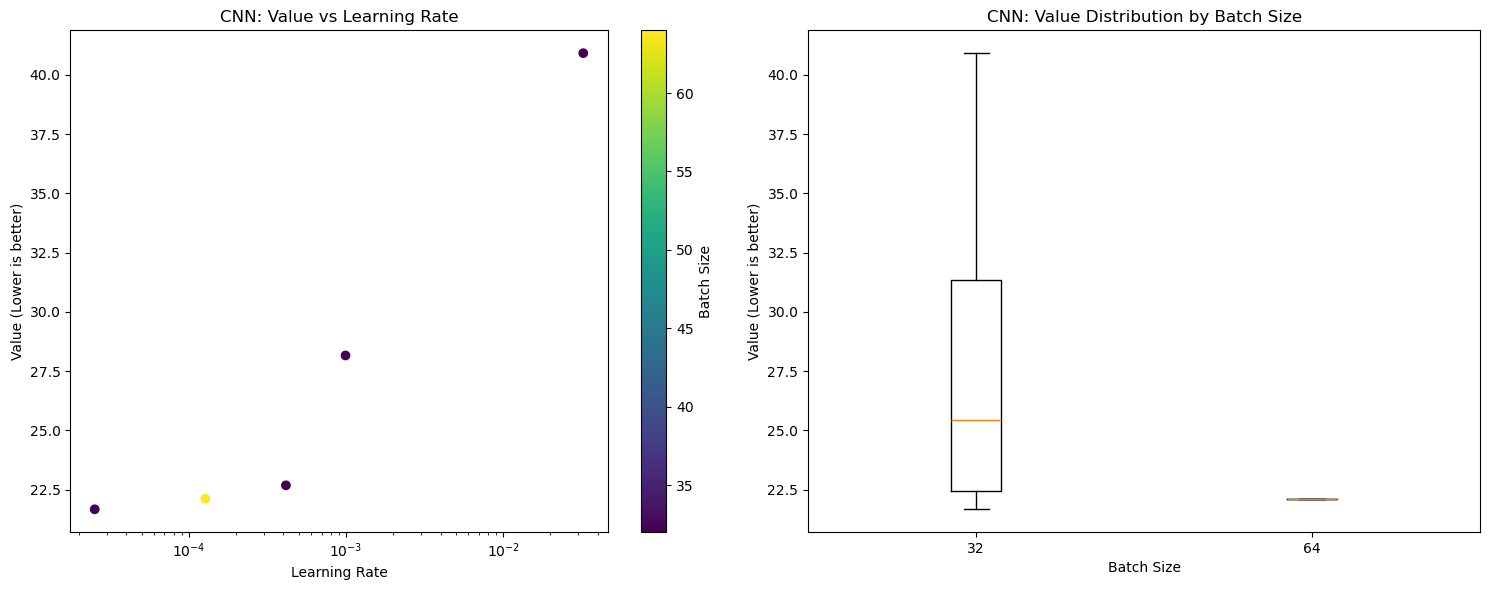

Best CNN trial:
  Value: 21.669536590576172
  Params:
    learning_rate: 2.5177669031357237e-05
    batch_size: 32
    num_epochs: 8
    dropout_rate: 0.17956545378570424


/var/folders/tt/bg81xkx10n788vrk6hd47xs80000gn/T/ipykernel_85058/2065934905.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(box_data, labels=unique_batch_sizes)


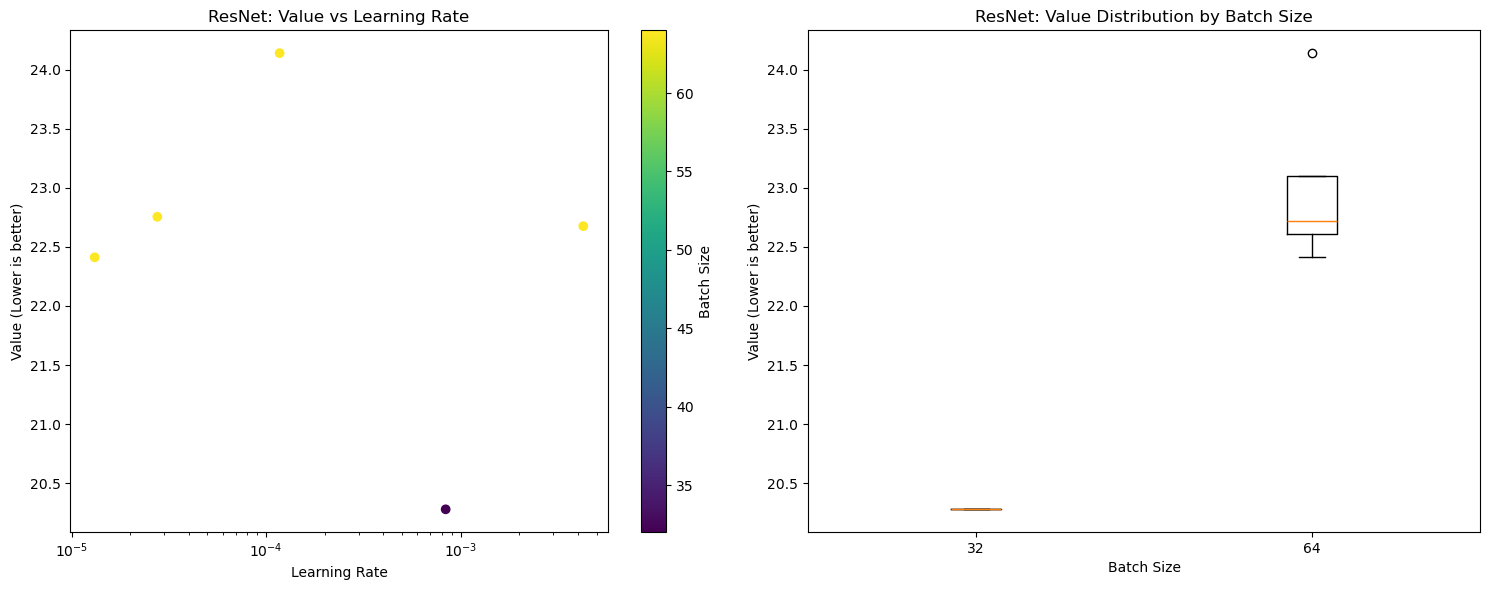

Best ResNet trial:
  Value: 20.27841567993164
  Params:
    learning_rate: 0.000837612197307521
    batch_size: 32
    num_epochs: 17
    dropout_rate: 0.1917737187153449


In [21]:
plot_trial_values(cnn_study, "CNN")
plot_trial_values(resnet_study, "ResNet")

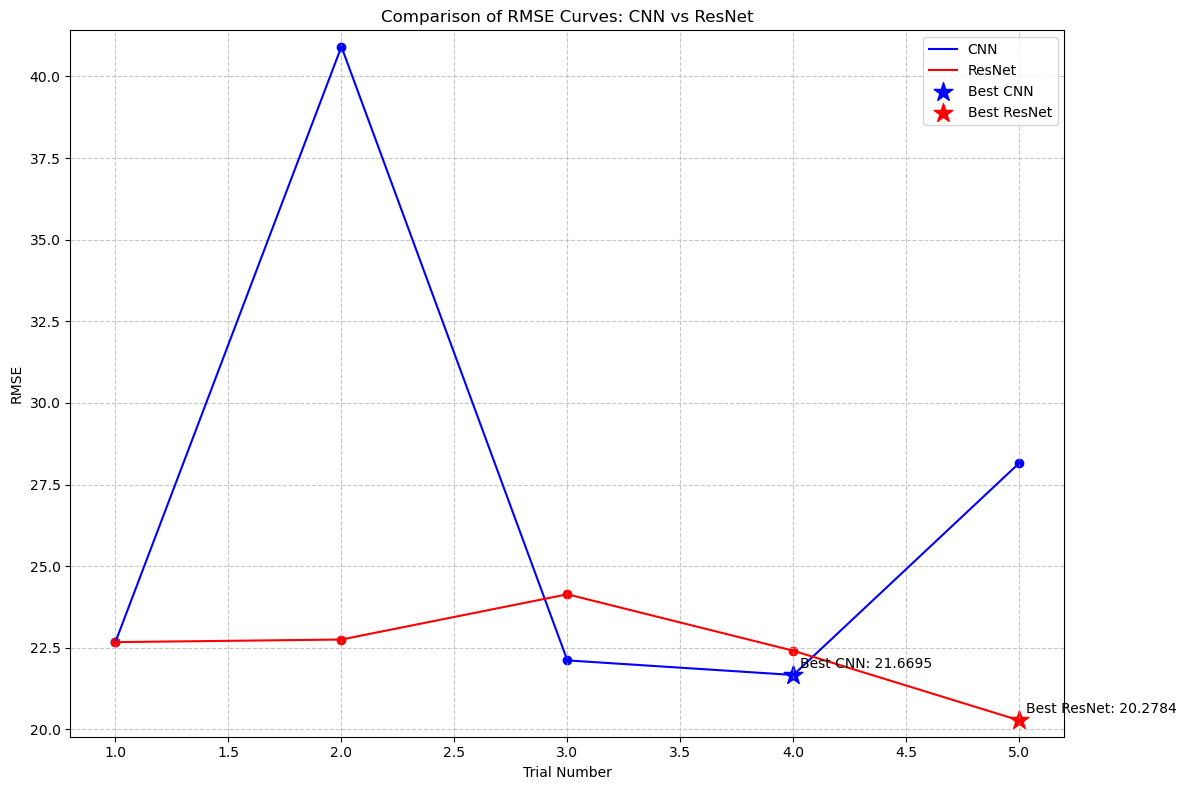

CNN - Best RMSE: 21.6695, Trial: 4
ResNet - Best RMSE: 20.2784, Trial: 5
CNN - Mean RMSE: 27.1082, Std Dev: 7.2910
ResNet - Mean RMSE: 22.4523, Std Dev: 1.2425


In [24]:
import matplotlib.pyplot as plt
import numpy as np

def compare_rmse_curves(cnn_study, resnet_study):
    plt.figure(figsize=(12, 8))
    
    # Extract RMSE values and trial numbers for CNN
    cnn_values = [t.value for t in cnn_study.trials if t.value is not None]
    cnn_trials = list(range(1, len(cnn_values) + 1))
    
    # Extract RMSE values and trial numbers for ResNet
    resnet_values = [t.value for t in resnet_study.trials if t.value is not None]
    resnet_trials = list(range(1, len(resnet_values) + 1))
    
    # Plot CNN curve
    plt.plot(cnn_trials, cnn_values, 'b-', label='CNN')
    plt.scatter(cnn_trials, cnn_values, color='blue')
    
    # Plot ResNet curve
    plt.plot(resnet_trials, resnet_values, 'r-', label='ResNet')
    plt.scatter(resnet_trials, resnet_values, color='red')
    
    # Add best RMSE points
    best_cnn_rmse = min(cnn_values)
    best_cnn_trial = cnn_values.index(best_cnn_rmse) + 1
    plt.scatter(best_cnn_trial, best_cnn_rmse, color='blue', s=200, marker='*', label='Best CNN')
    
    best_resnet_rmse = min(resnet_values)
    best_resnet_trial = resnet_values.index(best_resnet_rmse) + 1
    plt.scatter(best_resnet_trial, best_resnet_rmse, color='red', s=200, marker='*', label='Best ResNet')
    
    plt.xlabel('Trial Number')
    plt.ylabel('RMSE')
    plt.title('Comparison of RMSE Curves: CNN vs ResNet')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Improve y-axis scale (note: for RMSE, lower is better)
    plt.ylim(min(min(cnn_values), min(resnet_values)) - 0.5, 
             max(max(cnn_values), max(resnet_values)) + 0.5)
    
    # Add text annotations for best scores
    plt.annotate(f'Best CNN: {best_cnn_rmse:.4f}', 
                 xy=(best_cnn_trial, best_cnn_rmse), 
                 xytext=(5, 5), textcoords='offset points')
    plt.annotate(f'Best ResNet: {best_resnet_rmse:.4f}', 
                 xy=(best_resnet_trial, best_resnet_rmse), 
                 xytext=(5, 5), textcoords='offset points')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"CNN - Best RMSE: {best_cnn_rmse:.4f}, Trial: {best_cnn_trial}")
    print(f"ResNet - Best RMSE: {best_resnet_rmse:.4f}, Trial: {best_resnet_trial}")
    print(f"CNN - Mean RMSE: {np.mean(cnn_values):.4f}, Std Dev: {np.std(cnn_values):.4f}")
    print(f"ResNet - Mean RMSE: {np.mean(resnet_values):.4f}, Std Dev: {np.std(resnet_values):.4f}")

# After running the optimization studies
compare_rmse_curves(cnn_study, resnet_study)

In [ ]:
# Train final models with best hyperparameters
def train_final_model():
    if resnet_trial.value > cnn_trial.value:
        print("Best model is CNN")
        best_params = cnn_trial.best_params
        best_model = PyTorchModel(SimpleCNN, dropout_rate=best_params['dropout_rate'])
    else:
        print("Best model is ResNet")
        best_params = resnet_trial.best_params
        best_model = PyTorchModel(ResNet18Model, dropout_rate=best_params['dropout_rate'])

    val_loss, auc_roc = best_model.fit(train_loader, val_loader, best_params['num_epochs'], best_params['learning_rate'])

    torch.save(best_model.model.state_dict(), os.path.join('./model', f'best_model.pth'))

train_final_model(best_params)

## 5. Conclusion